In [51]:
import json
import os
import pickle
import sys

import numpy as np
from tqdm.notebook import tqdm

with open('../dirs.json', 'r') as f:
    dirs = json.load(f)
sys.path.append(dirs['root'])

from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import StandardScaler

from utils.ipm import NeuronLoader
from utils.metrics import DescriminationConfidenceEstimator as DCE
from utils.utils import mkeqdata
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.ndimage import gaussian_filter1d as smooth

nmb_rep = 100

outPath = os.path.join(dirs['out']['rsa'])
os.makedirs(outPath, exist_ok=True)

In [2]:
monkey = "both"
selectivity = "fast"

# grangerInfluence = {'itc2pfc': {}, 'pfc2itc': {}}
grangerInfluence = {}
with open("../utils/info.pkl", "rb") as handler:
    info = pickle.load(handler)
info = info[:165]
sIndex = ((info.sfr == "A") | (info.sfr == "BI"))
noneIndex = (info.cat == "none")
info = info[~noneIndex & sIndex].reset_index(drop=True)
itc = np.load(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}/ITCNoAvg.npy")
pfc = np.load(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}/PFCNoAvg.npy")
itc = itc[~noneIndex & sIndex]
pfc = pfc[~noneIndex & sIndex]

In [3]:
from sklearn.feature_selection import mutual_info_regression as minf
def movavg(inp, bl, ss):
    nbin = int(np.floor((inp.shape[2] - bl) / ss))
    out = np.nan * np.zeros((inp.shape[0], inp.shape[1], nbin))
    for ibin in range(nbin):
        out[:, :, ibin] = np.sum(inp[:, :, int(ibin*ss):int(ibin*ss)+bl], 2) / bl * 1000
    return out

In [4]:
bl, ss = 50, 5
itcData = movavg(itc, bl, ss)
pfcData = movavg(pfc, bl, ss)

In [53]:
mi = {}
for s, category in zip([info.fac, info.bod, info.art, info.nat], ["face", "body", "artificial", "natural"]):
    _mi = []
    for neuron in tqdm(range(itcData.shape[1])):
        r = itcData[:, neuron, :]
        
        __mi = []
        for time in range(itcData.shape[2]):
            __mi.append(minf(r[:, time].reshape(-1, 1), s, random_state=0))
        _mi.append(__mi)
    mi[category] = np.array(_mi).squeeze()

with open(os.path.join(dirs['out']['inf'], 'itc-per-category.pickle'), 'wb') as handle:
    pickle.dump(mi, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

In [33]:
mi = {}
for s, category in zip([info.fac, info.bod, info.art, info.nat], ["face", "body", "artificial", "natural"]):
    _mi = []
    for neuron in tqdm(range(pfcData.shape[1])):
        r = pfcData[:, neuron, :]
        
        __mi = []
        for time in range(pfcData.shape[2]):
            __mi.append(minf(r[:, time].reshape(-1, 1), s, random_state=0))
        _mi.append(__mi)
    print(f"{category}: finished")
    mi[category] = np.array(_mi).squeeze()

with open(os.path.join(dirs['out']['inf'], 'pfc-per-category.pickle'), 'wb') as handle:
    pickle.dump(mi, handle, protocol=pickle.HIGHEST_PROTOCOL)

(645, 170)

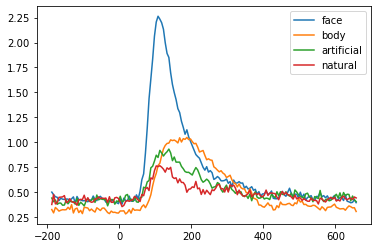

In [54]:
for category in ["face", "body", "artificial", "natural"]:
    plt.plot(np.arange(-200, 650, 5) + 12.5, mi[category].mean(0) / bl * 1000)
plt.legend(["face", "body", "artificial", "natural"])


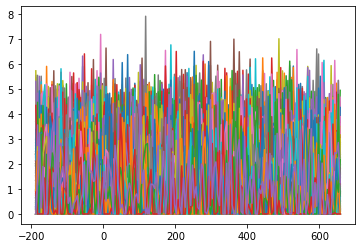

In [38]:
plt.plot(np.arange(-200, 650, 5) + 12.5, mi['face'].T / bl * 1000);

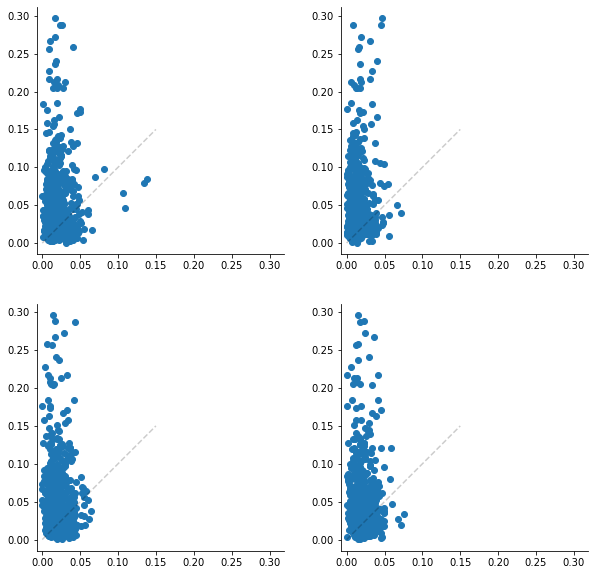

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
time = np.arange(-200, 650, 5) + 12.5

axs[0, 0].scatter(mi['face'][:, (time < 50) & (time > -50)].mean(1), \
    mi['face'][:, (time < 250) & (time > 150)].mean(1))
axs[0, 0].plot([0, .15], [0, .15], c='k', alpha=.2, ls='--')
axs[0, 0].axis('square')

axs[0, 1].scatter(mi['body'][:, (time < 50) & (time > -50)].mean(1), \
    mi['face'][:, (time < 250) & (time > 150)].mean(1))
axs[0, 1].plot([0, .15], [0, .15], c='k', alpha=.2, ls='--')
axs[0, 1].axis('square')

axs[1, 0].scatter(mi['natural'][:, (time < 50) & (time > -50)].mean(1), \
    mi['face'][:, (time < 250) & (time > 150)].mean(1))
axs[1, 0].plot([0, .15], [0, .15], c='k', alpha=.2, ls='--')
axs[1, 0].axis('square')

axs[1, 1].scatter(mi['artificial'][:, (time < 50) & (time > -50)].mean(1), \
    mi['face'][:, (time < 250) & (time > 150)].mean(1))
axs[1, 1].plot([0, .15], [0, .15], c='k', alpha=.2, ls='--')
axs[1, 1].axis('square')

sns.despine()